# solving the Thomson problem

In [187]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [266]:
def gen_charges(N, r):
    """each set of charges will have N charges and will be set on a sphere or radius r"""
    charges = []
    
    for charge in range(N):
        
        phi = np.random.uniform(0,2*np.pi)
        costheta = np.random.uniform(-1,1)

        theta = np.arccos( costheta )

        charges.append((r,theta,phi))
        
    
    return charges

def gen_population(size, N, r):
    pop = []
    for _ in range(size):
        pop.append(gen_charges(N,r))
    return pop

def test_charges(charges, r, eps = 0.01):
    """must be of radius r"""
    for charge in charges:
        assert np.abs( (charge[0] * np.sin(charge[1]) * np.cos(charge[2]) )**2 +
                      (charge[0] * np.sin(charge[1]) * np.sin(charge[2]) )**2 +
                      (charge[0] * np.cos(charge[1]))**2
            - r**2) < eps 
        
def compute_U(charges):
    
    def compute_U_partial(pair, k = 1, ei = 1, ej = 1):
        """contribution to U of a single pair is 1/r_ij (actually k* e_i * e_j / r_ij)"""
        
        def dist(pair, eps =0.000001):
            """distance is computed as sqrt( (x_0 - x_1)^2 +...) over all dimensions"""
            
            x0 = pair[0][0] * np.sin( pair[0][1]) * np.cos( pair[0][2] )
            y0 = pair[0][0] * np.sin( pair[0][1]) * np.sin( pair[0][2] )
            z0 = pair[0][0] * np.cos( pair[0][1] )
            x1 = pair[1][0] * np.sin( pair[1][1]) * np.cos( pair[1][2] )
            y1 = pair[1][0] * np.sin( pair[1][1]) * np.sin( pair[1][2] )
            z1 = pair[1][0] * np.cos( pair[1][1] )
            """
            r1 = pair[0][0]
            r2 = pair[1][0]
            theta1 = pair[0][1]
            theta2 = pair[1][1]
            phi1 = pair[0][2]
            phi2 = pair[1][2]
            
            #print(r1,r2,theta1,theta2,phi1,phi2)
            val = r1**2 + r2**2 - \
            2*r1*r2*(np.cos(theta1) * np.cos(theta2) * np.cos(phi1-phi2) + \
                         np.sin(phi1) * np.sin(phi2))
            print(val)
            d = np.sqrt(val)
            """
            d = np.sqrt(  (x0-x1)**2 + (y0-y1)**2 + (z0-z1)**2 )
            if d < eps:
                d = eps
            return d
        
        return (k* ei* ej)/dist(pair)
    

    U = 0.0
    for pair in it.combinations(charges, 2):
        U -= compute_U_partial(pair)
        
    return U

r = 1
charges = gen_charges(100,r)
test_charges(charges, r)
compute_U(charges)

-4919.15080589495

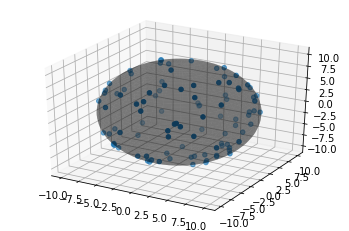

In [267]:
def plot_charges(charges, r = 1):
    x_points = [charge[0]* np.sin( charge[1]) * np.cos( charge[2] )  for charge in charges]
    y_points = [charge[0]* np.sin( charge[1]) * np.sin( charge[2] )  for charge in charges]
    z_points = [charge[0]* np.cos( charge[1])  for charge in charges]
    

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D(x_points, y_points, z_points)
    
    N=50
    stride=1
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    x = np.outer(r*np.cos(u), np.sin(v))
    y = np.outer(r*np.sin(u), np.sin(v))
    z = np.outer(r*np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, alpha=0.3, color='k')
    
    plt.show()
    
#test plot
population = gen_population(100,100,10)
s = sort_pop_by_fitness(population)
plot_charges(population[10],10)

In [268]:
def sort_pop_by_fitness(population, fitness_function = compute_U):
    return sorted(population, key=fitness_function, reverse=True)

def choice(sorted_by_fitness, fitness_sum):
    lowest_fitness = compute_U(sorted_by_fitness[0])
    offset = - lowest_fitness
    norm_fitness_sum = fitness_sum + offset*len(sorted_by_fitness)
    
    draw = np.random.uniform(low=0, high=1)
    
    cumulative = 0.0
    
    for i,charges in enumerate(sorted_by_fitness):
        fitness = compute_U(charges) + offset
        probability = (fitness / norm_fitness_sum) ###RIGUARDARE
        cumulative += probability
        
        if draw <= cumulative:
            return charges
    else:
        return charges

def crossover(first, second):
    """gets random part of the charges from the first and the other charges from the second
    - force selecting different indexes otherwise risk of same points
    -TODO for now, it may take nothing from first but at least one from second is always in"""

    charges_size = len(first)
    ratio = np.random.uniform(0,1.01)
    
    first = np.array(first)
    second = np.array(second)
        
    first_idxs = np.random.choice(np.arange(first.shape[0]), replace=False, size = int(ratio*len(first)))
    second_idxs = [idx for idx in np.arange(second.shape[0]) if not idx in first_idxs]

    first_contrib = first[first_idxs]
    second_contrib = second[second_idxs]
    #print(first_contrib, second_contrib)
    return list(first_contrib)+ list(second_contrib)

def mutate(ind, rate = 0.1):
    """perturbate theta, phi -- REMEMBER: an individual is a SET of charges"""
    new_ind = []
    selections = np.random.choice(len(ind), size = max(1, int(rate*len(ind))))

    for selection in selections:
        r = ind[selection][0] #not to be modified
        new_theta = ind[selection][1] + np.random.uniform(-0.05, 0.05)
        new_phi = ind[selection][1] + np.random.uniform(-0.05/2, 0.05/2) #phi has half range
        ##keep it inside boundaries
        #new_theta = min(max(new_theta, 0), 2*np.pi)
        #new_phi = min(max(new_phi, 0), np.pi)

        ind[selection] = [r,new_theta,new_phi]
    return ind

def make_next_gen(prev_population, ind_size, rate):
    next_gen = []
    sorted_by_fitness = sort_pop_by_fitness(prev_population)
    pop_size = len(prev_population)
    fitness_sum = sum(compute_U(charges) for charges in prev_population)
    
    for i in range(pop_size):
        first_mate = choice(sorted_by_fitness, fitness_sum)
        second_mate = choice(sorted_by_fitness, fitness_sum)
    
        individual = crossover(first_mate, second_mate)
        individual = mutate(individual, rate=rate)
        
        assert ind_size == len(individual), f'set of charges depleted: {len(individual)}'
        
        next_gen.append(individual)
    return next_gen

In [269]:
def make_ga(pop_size, N_charges, r, generations = 1000, rate=0.1):
    
    #gen population
    population = gen_population(pop_size, N_charges, r)
    #print(population)
    #do generations
    best_u = -99999999
    best_ind = population
    best_gen = -1
    for generation in range(generations):
        ranked = sort_pop_by_fitness(population)
        u = compute_U(ranked[0])
        if u > best_u:
            best_u = u
            best_ind = ranked[0]
            best_gen = generation
        plot_charges(ranked[0], r=r)
        
        print(f"best set of charges [generation {generation}] : {u}")
        print(f"worst set of charges [generation {generation}] : {compute_U(ranked[-1])}")

        population = make_next_gen(population, N_charges, rate=rate)
        
        
    print(f'best U: {best_u}')
    print(f'best gen: {best_gen}')
    return best_u, best_ind, best_gen

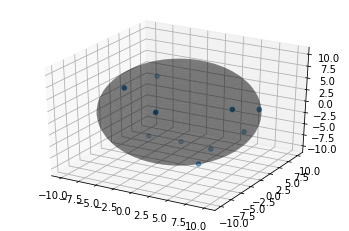

best set of charges [generation 0] : -3.9034666537667326
worst set of charges [generation 0] : -4.432476761110168


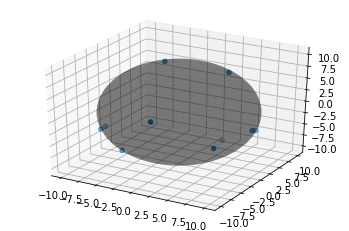

best set of charges [generation 1] : -3.8697416337315316
worst set of charges [generation 1] : -5.814453775844969


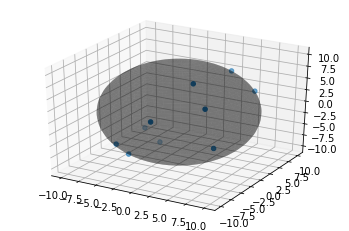

best set of charges [generation 2] : -4.149215183400205
worst set of charges [generation 2] : -5.699277660814444


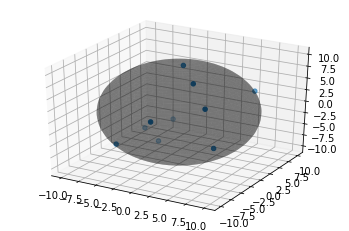

best set of charges [generation 3] : -4.076134264115652
worst set of charges [generation 3] : -1000005.7372980448


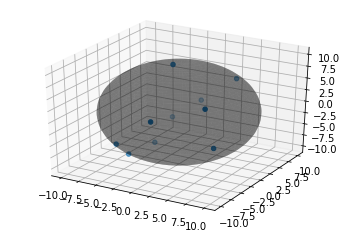

best set of charges [generation 4] : -3.837147645442095
worst set of charges [generation 4] : -2000003.895942675


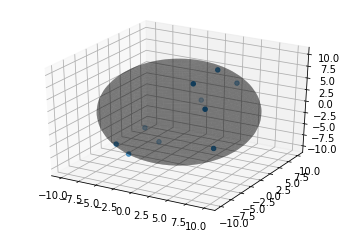

best set of charges [generation 5] : -3.9953281942716323
worst set of charges [generation 5] : -3000004.987882237


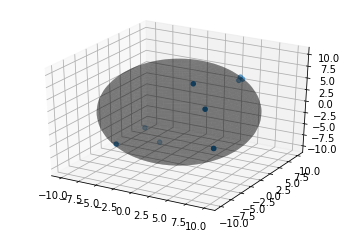

best set of charges [generation 6] : -1000006.0008826067
worst set of charges [generation 6] : -3000005.9465003046


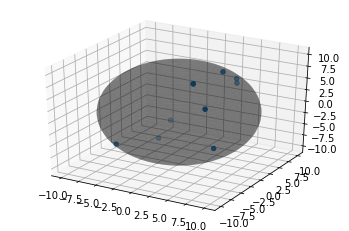

best set of charges [generation 7] : -1000004.3730274827
worst set of charges [generation 7] : -7000006.2471288


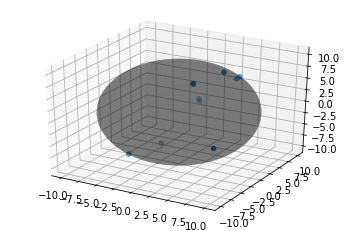

best set of charges [generation 8] : -1000005.7786517413
worst set of charges [generation 8] : -7000013.030214961


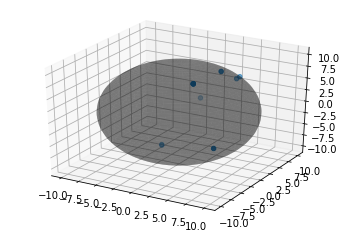

best set of charges [generation 9] : -3000009.886575761
worst set of charges [generation 9] : -10000009.732229792
best U: -3.837147645442095
best gen: 4


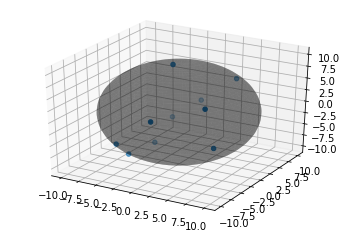

In [270]:
u,ind, gen = make_ga(pop_size=10, N_charges=10, r=10, generations=10, rate= 0.1)
plot_charges(ind, r = 10)
test_charges(ind, r = 10)